# Puffins Classifier

Puffins are three species of birds with brightly-coloured beaks. Here we create a classifier to identify the species of puffin based on its features.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## 1. Data Exploration and Cleaning

In [43]:
## Load the dataset

puffin_df = pd.read_csv("puffins.csv")
puffin_df.head()

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g,sex,year
0,Tufted,40.8,17.6,188.9,3283.0,female,2009
1,Horned,45.9,15.3,217.2,5537.0,male,2007
2,Atlantic,39.7,18.9,204.0,3797.5,male,2009
3,Atlantic,40.5,18.9,181.8,3479.0,female,2007
4,Atlantic,37.3,19.2,191.9,3528.0,female,2008


After a quick scan of the dataset, we investigate the suitability of some of the predictors.

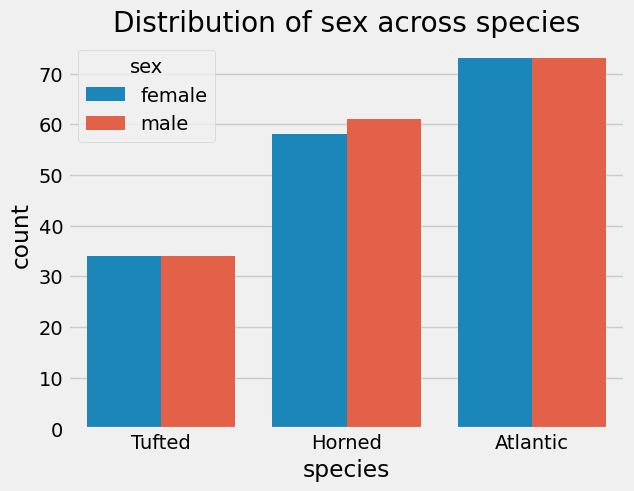

In [44]:
matplotlib.style.use('fivethirtyeight')
sns.countplot(x = "species", data = puffin_df, hue = "sex")  ## Hue colours by "sex" for easy comparison
plt.title("Distribution of sex across species")
plt.show()

It seems unlikely that the gender will provide information on the identification of species, although in some animals one gender may be more prevalent than the other. The above bar plot shows that in our dataset there are roughly as many males as there are females within each species. The even distribution of gender means that it is highly unlikely that the 'sex' will aid in species classification. It is also unlikely to generalise well to other puffins dataset. As such, we will drop this column.

Similarly, the year of data collection should have little effect on the predictions of species. Moreover, this information is unlikely to generalise well to other puffin data, especially those collected before or after the included years. Therefore, we will drop this column as well.

In [45]:
puffin_df.drop(['sex', 'year'], inplace=True, axis = 1)   ## Removes column "sex" and "year"

In [46]:
puffin_df.head()

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
0,Tufted,40.8,17.6,188.9,3283.0
1,Horned,45.9,15.3,217.2,5537.0
2,Atlantic,39.7,18.9,204.0,3797.5
3,Atlantic,40.5,18.9,181.8,3479.0
4,Atlantic,37.3,19.2,191.9,3528.0


In [47]:
puffin_df.shape   # Get the number of columns and rows in df

(344, 5)

Now our dataset contains 344 entries with 4 predictors. A quick scan reveals that 2 entries have missing data. 

In [48]:
puffin_df[puffin_df.isnull().T.any()]    # Extract all rows with missing values in any column

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
62,Atlantic,NaN,NaN,NaN,NaN
243,Horned,NaN,NaN,NaN,NaN


Since these rows are completely unusable, we will drop them as well.

In [49]:
puffin_df.dropna(inplace=True)           # Remove all rows with missing values

Now that we have a cleaned dataset with 342 complete entries, we will separate the features and labels.

In [50]:
X = puffin_df.iloc[:, 1:5]   ## Vector of features
y = puffin_df["species"]     ## Labels

## 2. Visualisation

Here we look at how the data cluster together to get an idea of which algorithm to apply.

In [51]:
from itertools import combinations
feature_comb = list(combinations(list(puffin_df.columns)[1:5], 2))  ## Create a combination of all features

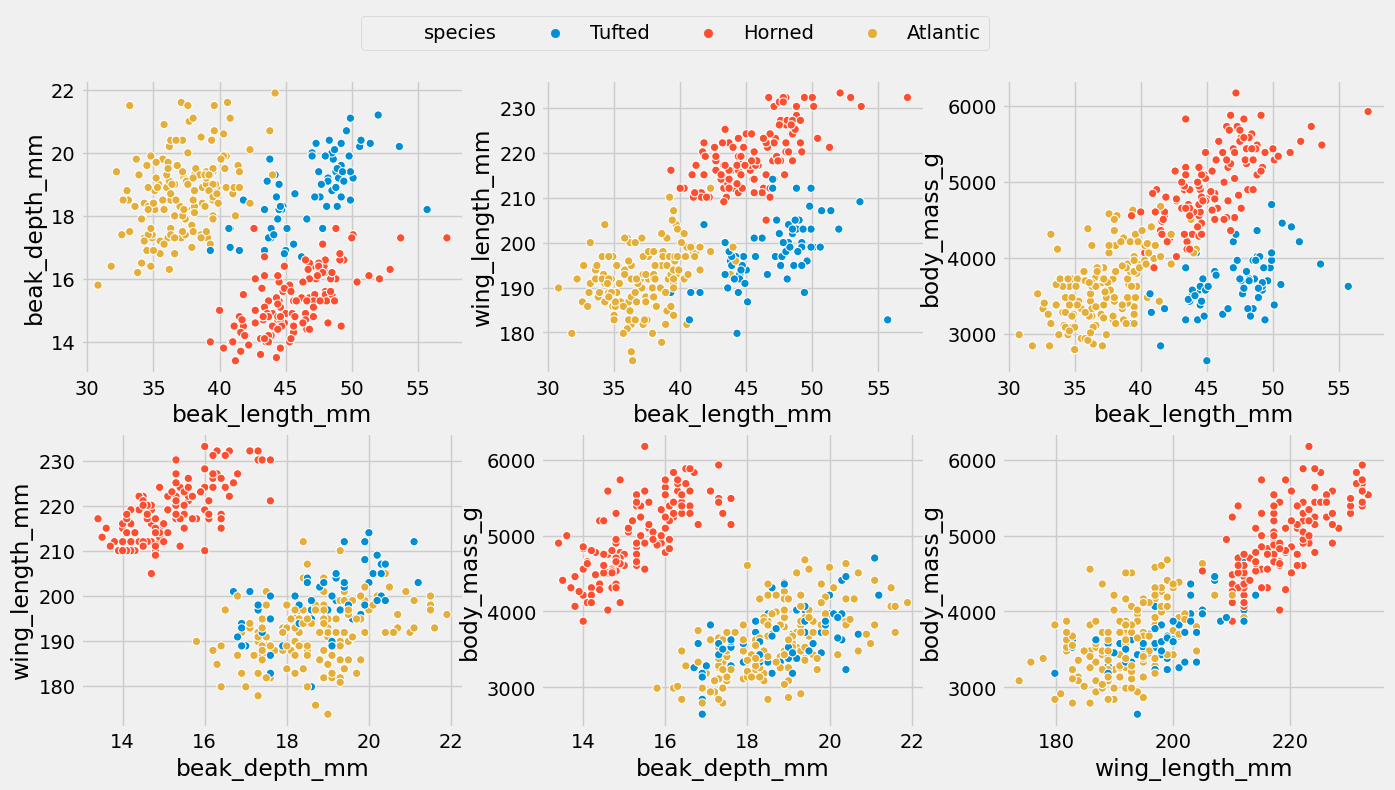

In [52]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
for row in range(2):           ## Loop through the rows and columns of subplots and create scatter plot one by one 
    for col in range(3):
        if row == 1:           ## Second row, add 2 to index to get the right data and position
            ax = sns.scatterplot(x = feature_comb[row+col+2][0], y = feature_comb[row+col+2][1], data = puffin_df, hue="species", ax=axes.flatten()[row+col+2])
        else:
            ax = sns.scatterplot(x = feature_comb[row+col][0], y = feature_comb[row+col][1], data = puffin_df, hue="species", ax=axes.flatten()[row+col])
        ax.get_legend().remove()           ## Remove legend, later plot one legend for entire figure
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(.45, 0.98))  ## Put legend on top outside of plot area
plt.show()

It seems that the data is generally separable, although there exist some cases that might be more ambiguous, in particular

1. wing length vs beak depth
2. body mass vs beak depth
3. body mass vs wing length

for Atlantic and Tufted puffins.

Next we will split them into training and testing set so that we can validate our model later. We use the default values for train_test_split which puts 25% of the data in the test set.

In [53]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)  # Random state for reproducible results

## 3. Classifications

## 3.1 K-nearest Neighbours (KNN)

Since we have labels for our data, this is clearly a supervised problem. We will first try to classify the puffins with K-nearest Neighbours (KNN). This is a non-parametric algorithm that classifies data based on its distance to other data points in the training set.


This algorithm does not hold prior assumption on the underlying models that generated the data. It is also relatively easy to implement on multiclass classification problems, and can be easily updated with the addition of new data. 

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1).fit(train_X, train_y)  ## Create KNN classifier and train it

In [55]:
knn_model.score(test_X, test_y)   ## Return accuracy score on testing set

0.9069767441860465

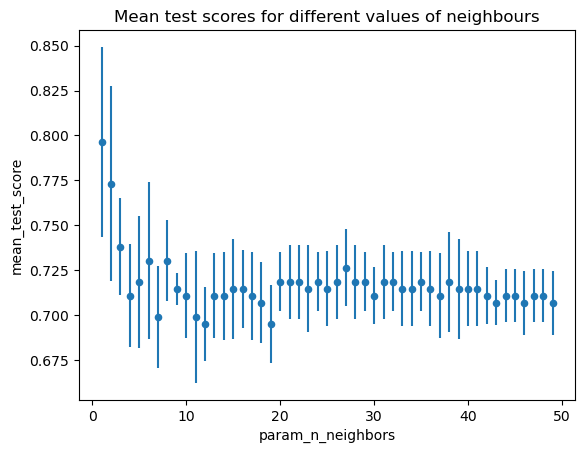

In [56]:
## Here we use GridSearch to search for the best number of neighbours

from sklearn.model_selection import GridSearchCV
matplotlib.style.use('default')

## Test from 1 to 50
parameters = {
    "n_neighbors" : range(1, 50),
}

puffin_clf = GridSearchCV(KNeighborsClassifier(), parameters).fit(train_X, train_y)  ## Fit data and calculate best number of neighbours

cv_results = pd.DataFrame(puffin_clf.cv_results_)              ## Get the summary statistics and plot neighbour numbers against test scores
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")
plt.title("Mean test scores for different values of neighbours")
plt.show()

### - Feature Scaling

The best hyperparameter is 1, according to the grid search results. However, when looking through the data, it looks like the features are on different scales. Since the algorithm operates on distance-based metrics such as Euclidean or Manhattan distance, it can be very sensitive to scaling. To rectify this, we will normalise the data with `StandardScaler`.

In [57]:
## Generate an instance of StandardScaler and normalise both training and testing features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()        
train_X_scaled = scaler.fit_transform(train_X.astype(np.float64))
test_X_scaled = scaler.fit_transform(test_X.astype(np.float64))

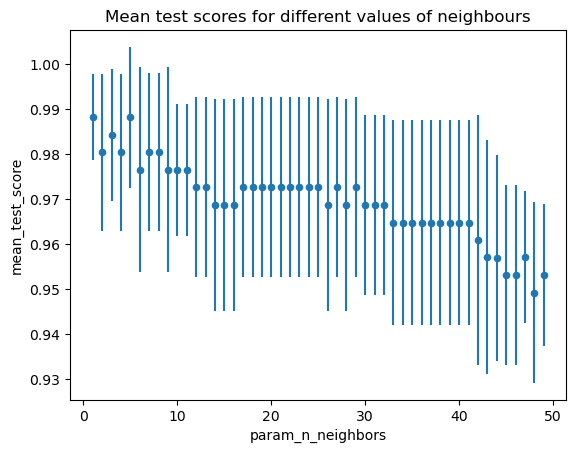

In [58]:
## Redo GridSearch after normalisation

puffin_clf_scaled = GridSearchCV(KNeighborsClassifier(), parameters).fit(train_X_scaled, train_y)

cv_results = pd.DataFrame(puffin_clf_scaled.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")
plt.title("Mean test scores for different values of neighbours")
plt.show()

In [59]:
puffin_clf_scaled.score(test_X_scaled, test_y)

0.9534883720930233

In [60]:
puffin_clf_scaled.best_params_

{'n_neighbors': 1}

There is significant improvement (~20%) over all hyperparameters, it is evident that normalisation is a crucial step before applying KNN algorithm, although the best performing hyperparameter is still 1. A very low `k` is not advisable in general as small values tend to overfit the data and the algorithm may perform worse on other data (not generalisable). Small changes in the data can have significant effect on the classification system. It can be easily skewed by outliers. 

On average, most hyperparameters achieved a mean score over 0.95, as is the score on the testing set. This suggests a very strong prediction capabilities by the algorithm on this particular dataset. 

### - Sampling Effect

KNN algorithm can be sensitive to sampling effects on several levels. First, if the distribution of labels in the training sets is significantly different from the overall dataset, classes may be over- or underrepresented and skew the classification.

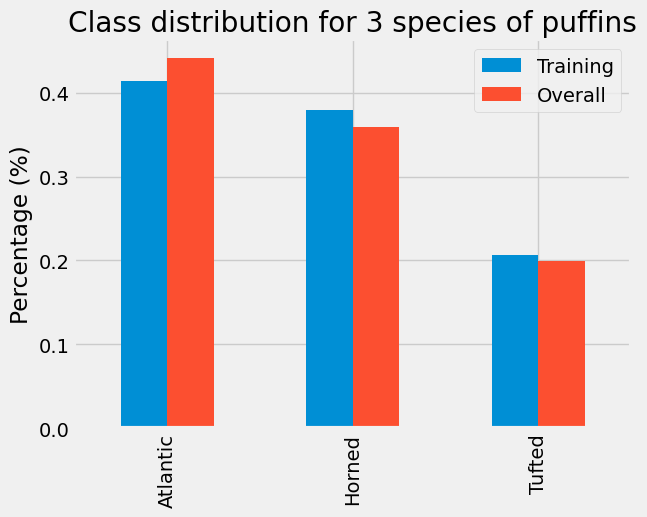

In [61]:
matplotlib.style.use('fivethirtyeight')
## Here we plot the class distribution in both training and overall dataset

species_stratification1 = pd.DataFrame({"Training":train_y.value_counts()/len(train_y), 
                                        "Overall":puffin_df["species"].value_counts()/len(puffin_df)})   ## Plot as percentage of all data by dividing by length of df
species_stratification1.plot.bar()
plt.ylabel("Percentage (%)")
plt.title("Class distribution for 3 species of puffins")
plt.show()

It seems that their distribution is similar, though small differences are visible. Here we will stratify the data and repeat the analysis.

In [62]:
## Apply a stratified version of train_test_split

strat_train_X, strat_test_X, strat_train_y, strat_test_y = train_test_split(X, y, random_state=42, stratify=y)

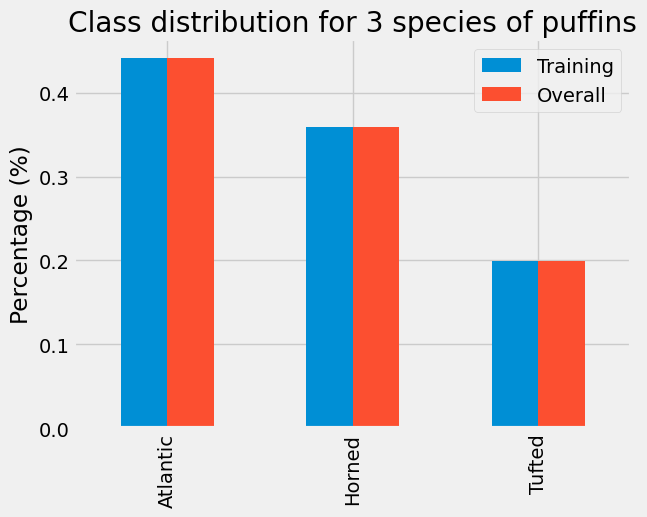

In [63]:
## Replot the distributions

species_stratification2 = pd.DataFrame({"Training":strat_train_y.value_counts()/len(strat_train_y),
                                        "Overall":puffin_df["species"].value_counts()/len(puffin_df)})
species_stratification2.plot.bar()
plt.ylabel("Percentage (%)")
plt.title("Class distribution for 3 species of puffins")
plt.show()

Now that the distribution is is more even within species, we will perform knn again.

In [64]:
## Normalise the stratiifed data
strat_train_X_scaled = scaler.fit_transform(strat_train_X.astype(np.float64))
strat_test_X_scaled = scaler.fit_transform(strat_test_X.astype(np.float64))

## and perform another GridSearch to see if best hyperparameter changes
strat_puffin_clf_scaled = GridSearchCV(KNeighborsClassifier(), parameters).fit(strat_train_X_scaled, strat_train_y)

strat_cv_results = pd.DataFrame(strat_puffin_clf_scaled.cv_results_)

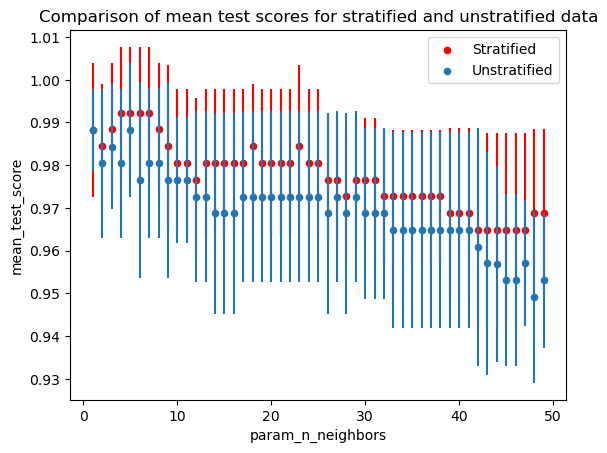

In [65]:
## Plot stratified and unstratified results together for comparison

matplotlib.style.use('default')
fig, ax = plt.subplots()
strat_cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", ax=ax, c="red", label = "Stratified")
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", ax=ax, label = "Unstratified")
plt.title("Comparison of mean test scores for stratified and unstratified data")
plt.show()

In [66]:
strat_puffin_clf_scaled.score(strat_test_X_scaled, strat_test_y)

0.9767441860465116

In [67]:
strat_puffin_clf_scaled.best_params_   ## Get the best number of neighbours

{'n_neighbors': 4}

There is a slight but clear improvement of sample stratification prior to applying the algorithm. Both GridSearch score and test score improved by around 2%. However, now the best performing number of neighbours is 4.

Another form of bias may come from data sampling itself. The proportion of the three species in the dataset are not balanced. More data from one class means more potential neighbours, and a higher probability that an unknown puffin will be classified as Atlantic. The effect is more pronounced when `k` is large. This can be mitigated in the sampling step, to include similar percentage of observations of each class, or only selecting a portion of data such that classes are equally represented. However, this did not seem to cause major concern in our model based on the test score, and further trimming would reduce a lot of usable data. This, however, should be considered when adding more data.

### - Other weaknesses

KNN algorithm is also sensitive to outliers, especially when the number of neighbours is low.
The algorithm is also memory-inefficient. All data have to be stored for future classification. As more data are collected or dimensionality increases, the algorithm can take a lot of memory and time to perform classifications. In short, it may not always be scalable to larger datasets.  

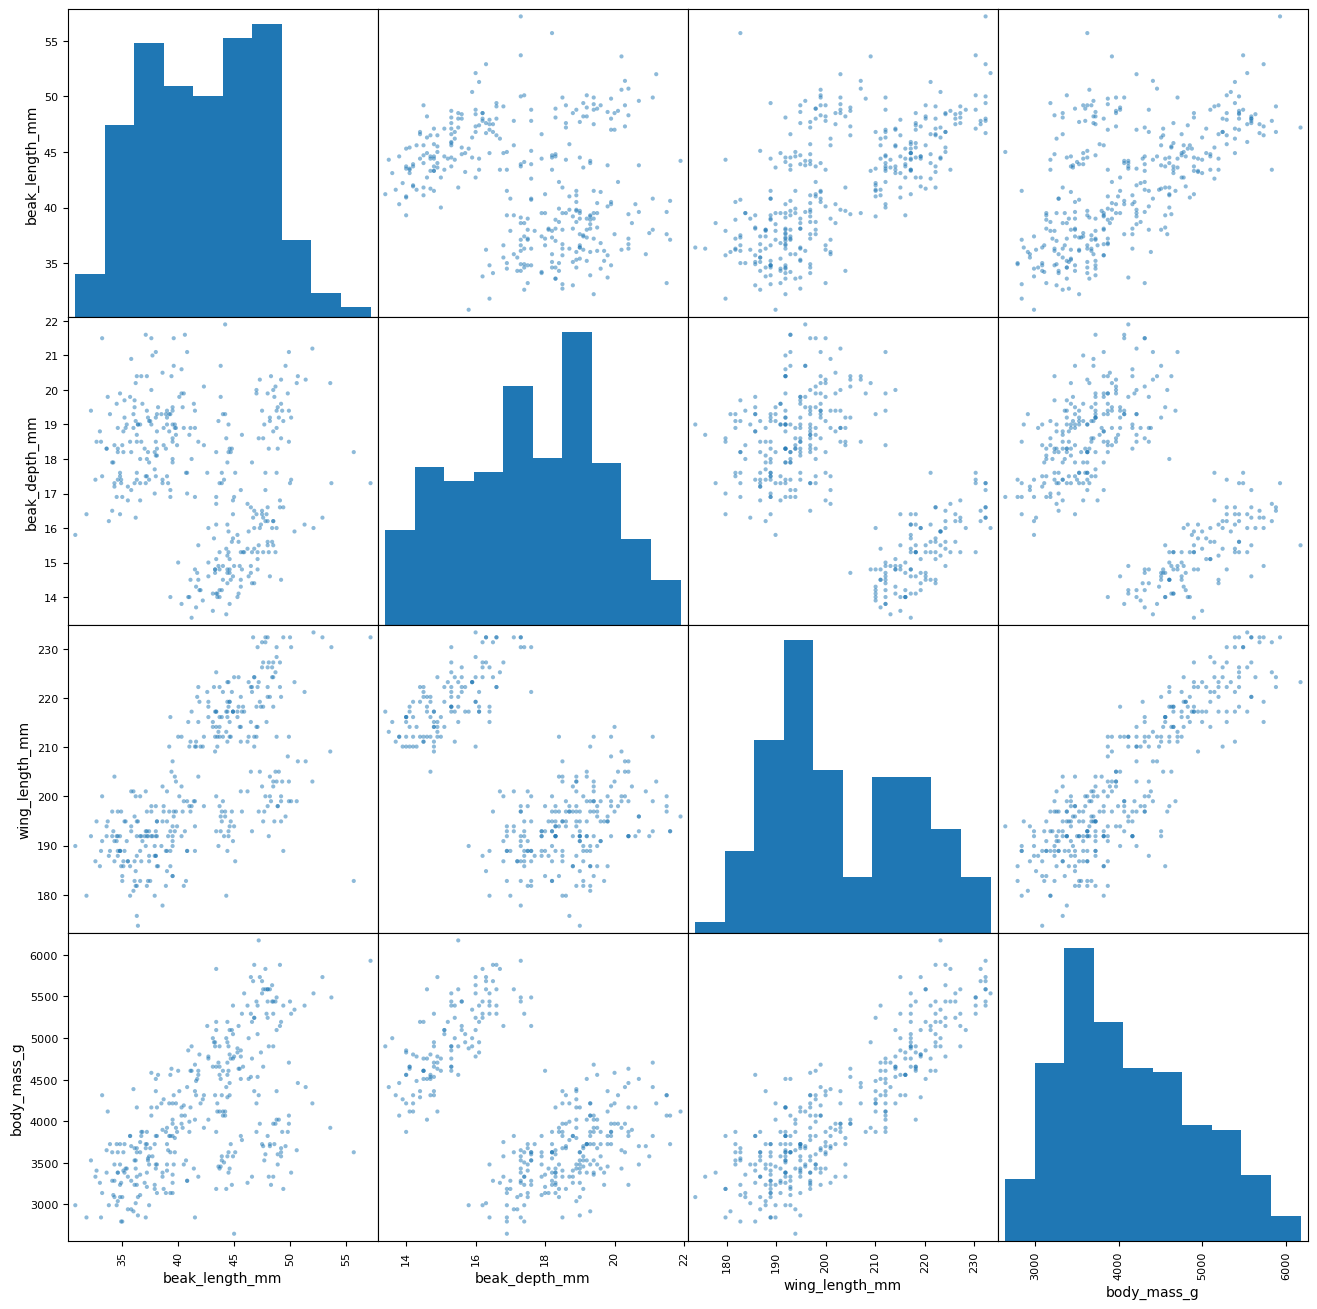

In [68]:
## Here we look at the data distributions and correlations

from pandas.plotting import scatter_matrix

a = scatter_matrix(puffin_df, figsize=(16, 16))

From the matrix, outlier does not seem to be a serious problem, which might be the explanation why low number of `k` performs relatively well. 
From the correlation plot, wing length and body mass seems to be strongly correlated.

In [69]:
puffin_df.corr()

,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
beak_length_mm,1.000000,-0.236537,0.656369,0.595105
beak_depth_mm,-0.236537,1.000000,-0.585531,-0.473464
wing_length_mm,0.656369,-0.585531,1.000000,0.871209
body_mass_g,0.595105,-0.473464,0.871209,1.000000


Wing length and body mass are around 87% correlated. This might suggest that body mass offers very little new information if wing length is included in the algorithm.

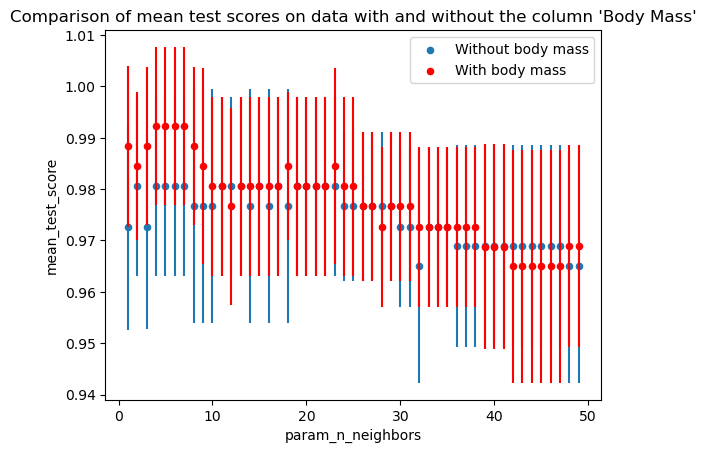

In [70]:
## Here we compare the scores if we include and exclude body mass in our data

trimmed_train_X = strat_train_X_scaled[:, [0, 1, 2]]  ## Exclude body mass (last column)
trimmed_test_X = strat_test_X_scaled[:, [0, 1, 2]]

trimmed_puffin_clf = GridSearchCV(KNeighborsClassifier(), parameters).fit(trimmed_train_X, strat_train_y)   ## GridSearch results can be used directly as the best model
trimmed_cv_results = pd.DataFrame(trimmed_puffin_clf.cv_results_)


fig, ax = plt.subplots()
trimmed_cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", label = "Without body mass", ax=ax)
strat_cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", ax=ax, c="red", label = "With body mass")
plt.title("Comparison of mean test scores on data with and without the column 'Body Mass'")
plt.show()

In [71]:
trimmed_puffin_clf.score(trimmed_test_X, strat_test_y)

0.9534883720930233

Even though trimming body mass lowers the predictive scores slightly, in cases where memory is a concern, reducing dimensionality by excluding body mass can improve efficiency while maintaining good performance. There is a trade-off between performance and efficiency. To evaluate KNN algorithm, we will train two more classifiers and compare their performance.

### 3.2 Logistic Regression

One popular type of classifier is the multinomial logistic regression, it is a parametrised algorithm that attempts to explain the underlying relationships between the features and labels. It assigns probabilities for a set of features to be of each class. The class with the highest probability is the predicted class. It also estimates the importance of each feature. Unlike KNN, logistic regression does not need to store all training data to perform classification, making it more memory-efficient.

However, there is an underlying assumption the features and labels are linearly related after logit transformation. It generally performs poorly on non-linearly separable data. Judging from the scatter plot in part 2, it seems reasonable to try logistic regression.

In [72]:
## Here we implement LogisticRegression by first creating an instance of the algorithm, then fit it to our training set and score its accuracy

from sklearn.linear_model import LogisticRegression

puffin_log_reg = LogisticRegression()
puffin_log_reg.fit(strat_train_X_scaled, strat_train_y)

puffin_log_reg.score(strat_test_X_scaled, strat_test_y)

0.9883720930232558

## 3.3 Naive Bayes Classifier

Another type of classifier is the Naive Bayes classifier. It is based on Bayes' theorem, and computes the likelihood of an observation belonging to a certain class given its features. It also has a relatively small memory footprint compared to k-nearest neighbour algorithm. Naive Bayes is quite fast and scalable as well. A potential source of model misspecification is this algorithm assumes independence among the features. As we have shown, the features are likely to be correlated.

In [73]:
## Here we implement Naive Bayes classifier in the same way

from sklearn.naive_bayes import GaussianNB

puffin_bayes = GaussianNB()
puffin_bayes.fit(strat_train_X_scaled, strat_train_y)
puffin_bayes.score(strat_test_X_scaled, strat_test_y)

0.9534883720930233

## 4. Model evaluations

Simply looking at the score of one instance of the data, it seems that logistic regression is the best-performing algorithm. However, the differences are very small and model performance might change depending on the way we split the training and testing sets. To minimise this variation and get a better overall idea of their performance, we use k-fold cross-validation. Since we have a relatively small dataset, we will use `cv=5`. Chunks that are too small might increase variability. 

In [74]:
## Here we implement cross validation, and get the accuracy score for each algorithm on the training set

from sklearn.model_selection import cross_val_score

kneighbour_scores = cross_val_score(strat_puffin_clf_scaled, strat_train_X_scaled, strat_train_y, scoring="accuracy", cv=5)
logistic_scores = cross_val_score(puffin_log_reg, strat_train_X_scaled, strat_train_y, scoring="accuracy", cv=5)
bayes_scores = cross_val_score(puffin_bayes, strat_train_X_scaled, strat_train_y, scoring="accuracy", cv=5)

In [75]:
## score_summary is a function for generating summary statistics of accuracy score, it returns the mean and sd of the scores in a numpy array

def score_summary(scores):
    return np.array([round(scores.mean()*100, 2), 
                     round(scores.std()*100, 2)])

In [76]:
## Here we group the scores in a dataframe for easy comparison

cross_val_scores = pd.DataFrame({"k-neighbour":score_summary(kneighbour_scores), 
                                "Logistic":score_summary(logistic_scores), 
                                "Naive Bayes":score_summary(bayes_scores)}, 
                               index = ["Mean", "SD"])

cross_val_scores

,k-neighbour,Logistic,Naive Bayes
Mean,98.44,98.45,97.27
SD,1.47,1.44,1.56


In [77]:
## Get a basline score based on the most abundant class

baseline = (y == "Atlantic").sum()/len(y)
print("Baseline:", baseline)

Baseline: 0.4415204678362573


All three models perform very well (>97% accuracy) compared to the baseline where we simply guess the most abundant class every time (~44%).

The performance of KNN and logistic regression is very similar, while Naive Bayes has slightly lower accuracy and more variability.

So far, we have only measured their performance with accuracy. Other common metrics to measure classification success are precision and recall. 

### - Precision 

Precision is calculated by dividing the true positives (TP) over the sum of true positives and false positives (FP). Intuitively, it can be thought of as the percentage of correct positive identification. 

${Precision} = \dfrac{TP}{TP + FP}$

In [78]:
## Here we use cross_val_predict to get the class predictions of the cross validation test
## The predictions will enable us to calculate precision and recall scores.

from sklearn.model_selection import cross_val_predict

kneighbour_train_predict = cross_val_predict(strat_puffin_clf_scaled, strat_train_X_scaled, strat_train_y, cv=5)
logistic_train_predict = cross_val_predict(puffin_log_reg, strat_train_X_scaled, strat_train_y, cv=5)
bayes_train_predict = cross_val_predict(puffin_bayes, strat_train_X_scaled, strat_train_y, cv=5)

In [79]:
## Again we group the precision for each class in a dataframe for easy comparison

from sklearn.metrics import precision_score, recall_score

precision_matrix = pd.DataFrame({"k-neighbour": precision_score(strat_train_y, kneighbour_train_predict, average = None), 
                                "Logistic": precision_score(strat_train_y, logistic_train_predict, average = None), 
                                "Naive Bayes": precision_score(strat_train_y, bayes_train_predict, average = None)}, 
                               index = strat_puffin_clf_scaled.classes_)

precision_matrix

,k-neighbour,Logistic,Naive Bayes
Atlantic,0.990991,0.973913,0.964912
Horned,1.000000,1.000000,1.000000
Tufted,0.943396,0.979592,0.940000


### - Recall

Recall is calculated by dividing the total true positives (TP) over the sum of true positives and false negatives (FN). Intuitively, it can be thought of as the percentage of actual positives correctly classified.

${Recall} = \dfrac{TP}{TP + FN}$

In [80]:
## And we create another dataframe for the recall score in the same way

recall_matrix = pd.DataFrame({"k-neighbour": recall_score(strat_train_y, kneighbour_train_predict, average = None), 
                                "Logistic": recall_score(strat_train_y, logistic_train_predict, average = None), 
                                "Naive Bayes": recall_score(strat_train_y, bayes_train_predict, average = None)}, 
                               index = strat_puffin_clf_scaled.classes_)

recall_matrix

,k-neighbour,Logistic,Naive Bayes
Atlantic,0.973451,0.991150,0.973451
Horned,1.000000,1.000000,1.000000
Tufted,0.980392,0.941176,0.921569


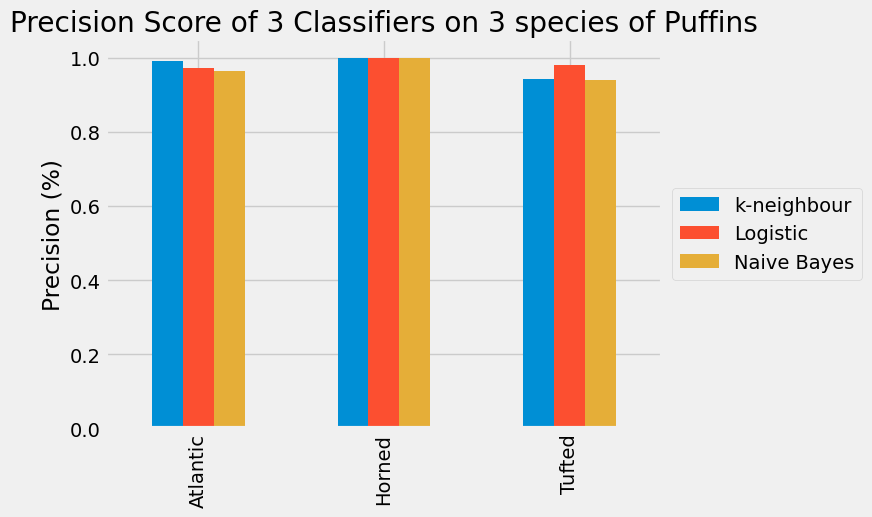

In [81]:
## Here we visualise the precision scores of the 3 classifiers on the 3 species

matplotlib.style.use('fivethirtyeight')
axes = precision_matrix.plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  ## Move legend box out of plotting area, otherwise it covers some part of the plot
plt.title("Precision Score of 3 Classifiers on 3 species of Puffins")
plt.ylabel("Precision (%)")
plt.show()

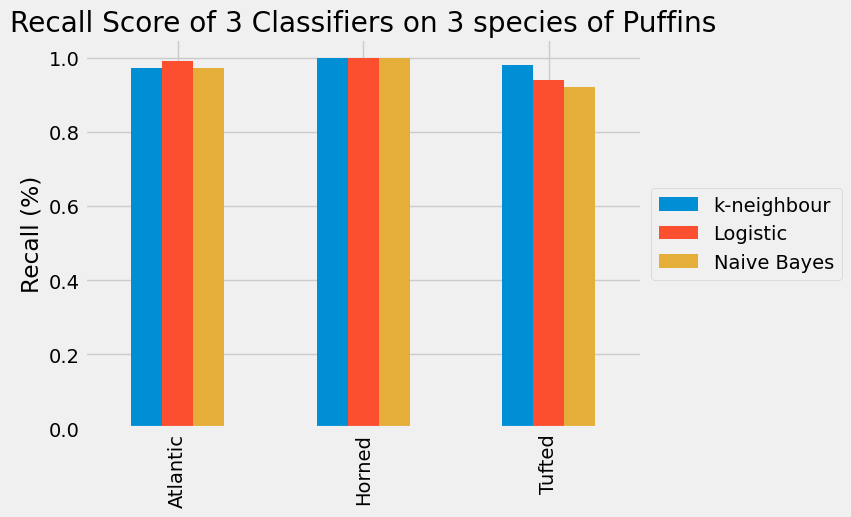

In [82]:
## and we visualise the recall scores in a similar way

axes = recall_matrix.plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))        ## Move legend box out of plotting area, otherwise it covers some part of the plot
plt.title("Recall Score of 3 Classifiers on 3 species of Puffins") 
plt.ylabel("Recall (%)")
plt.show()

It seems that Horned puffins are the easiest to classify, whereas a small percentage of Atlantic and Tufted puffins are misclassified for all classifiers. This is unsurprising as we have seen in part 2, the beak depth, wing length and body mass of Atlantic and Tufted puffins are more similar. 

In these borderline cases, k-neighbour algorithm has a higher precision and lower recall for Atlantic puffins, meaning it tend to classify an ambiguous puffin as Atlantic. The reverse is observed in logistic regression, meaning it is more likely to classify as Tufted.

# 4. Conclusion

Here we have evaluated the performance of common classifiers on a dataset of puffins. Data cleaning was first performed to remove the gender and year of collection. Observations with missing data were also trimmed. The effects of feature scales, as well as sample stratification, were explored and corrected for as much as possible. In total, three classifiers were tested and their general approach and learning method is summarised in the following table.

| | K-nearest Neighbour | Logistic Regression  | Naive Bayes  |
|---|---|---|---|
| Statistical Approach  | Discriminative  |  Discriminative | Generative |
| Learning Method  | Non-parametric  |  Parametric | Parametric |

> - #### Discriminative model
>
> Discriminative model, as its name suggests, discriminates against different classes based on the provided signals. It distinguishes boundaries separating the data and bins them accordingly. The model may not reflect the underlying process.


> - #### Generative model
>
> Generative model attempts to construct the joint probabilities of both the features and the labels p(X, y). It models the distribution of each class, instead of learning the boundaries. 

> - #### Parametric
>
> Parametric models usually have assumptions about the data, and assigns values to parameters during the training process. These methods are usually fast and require less memory. Only summary statistics are stored once model is trained. They might also be more constrained and fit poorly when model misspecification occurs.


> - #### Non-parametric
>
> Non-parametric models do not have strong assumptions about the model that generated the data, and do not estimate parameters. As such, they can be more flexible. However, they are also slower and memory-intensive. They generally are less helpful in understanding the underlying model.

In total, the performance of the classifiers are explored with the following metrics.

1. Score on testing set
2. Cross Validation Scores
3. Precision and Recall

All models perform reasonably well. In general, they all have an accuracy of over 95% on the test set and in cross-validation. KNN and logistic regression seems to slightly outperform Naive Bayes, although the differences are marginal. Naive Bayes also seems to have more variability when looking at the standard deviation of the cross-validation results. The performance of KNN and logistic regression is similar. 

Some instances of Atlantic and Tufted puffins seems to be more ambiguous, while perfect prediction scores are recorded for Horned puffins regardless of the classifier used. From the results of precision-recall analysis, it seems that KNN would be more likely to misclassify Atlantic puffins as Tufted, while the reverse is true for logistic regression. 

Depending on the specific application, one classifier might more useful than others. For example, if misclassification as Tufted is a more serious problem than misclassification as an Atlantic, one might opt for KNN algorithm. However, given similar performance, logistic regression is the more memory-efficient choice as a general-purpose classifier. 

Nonetheless, the size of the dataset is quite small. More data will generally give a fairer representation of the algorithm performance. One particular point to note is the unbalanced class. This tends to affect the predictions of underrepresented class. Although this seems to have little effect on the classifiers, correcting for this might change the ranking of the classifiers. Feature independence might also be a potential source of problem. All features used tend to concern size of body parts, and a bird with longer wing span would very likely have a larger body size. Collecting new features, such as colour, might add additional information and improve the predictions of the classifiers.